In [1]:
# -*- coding: utf-8 -*-

"""Cross correlation between each clusters' timeseries with NPGO index."""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


def full_ccf(x, y):
    """
    Computes cross-correlation between two series x and y.
    Returns the full correlation and the lags.
    """
    x = np.asarray(x, dtype=float).ravel()
    y = np.asarray(y, dtype=float).ravel()

    # Mean removal (Anomaly)
    x = x - x.mean()
    y = y - y.mean()

    # Correlation
    corr = np.correlate(x, y, mode="full")

    # Normalization (Pearson correlation coeff scale -1 to 1)
    # Note: This normalization assumes stationarity within the window
    corr /= np.std(x) * np.std(y) * len(x)

    # Generate lags
    lags = np.arange(-len(x) + 1, len(x))

    return lags, corr

In [2]:
# --- Main Execution ---

# 1. Load NPGO Index
npgo_index = np.loadtxt(
    "../Data/npgo.data",
    skiprows=42,
    usecols=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    max_rows=33,
)
# print(npgo_index)
y = np.mean(npgo_index, axis=1)
# print(y.shape)
# 2. Load Cluster Counts
norm_counts = pd.read_csv(
    "../Data/u850_cluster_counts.csv", usecols=range(1, 10)
)
X = norm_counts.to_numpy()

# 데이터 길이 일치 확인
min_len = min(len(y), len(X))
y = y[:min_len]
X = X[:min_len, :]

n_clusters = X.shape[1]

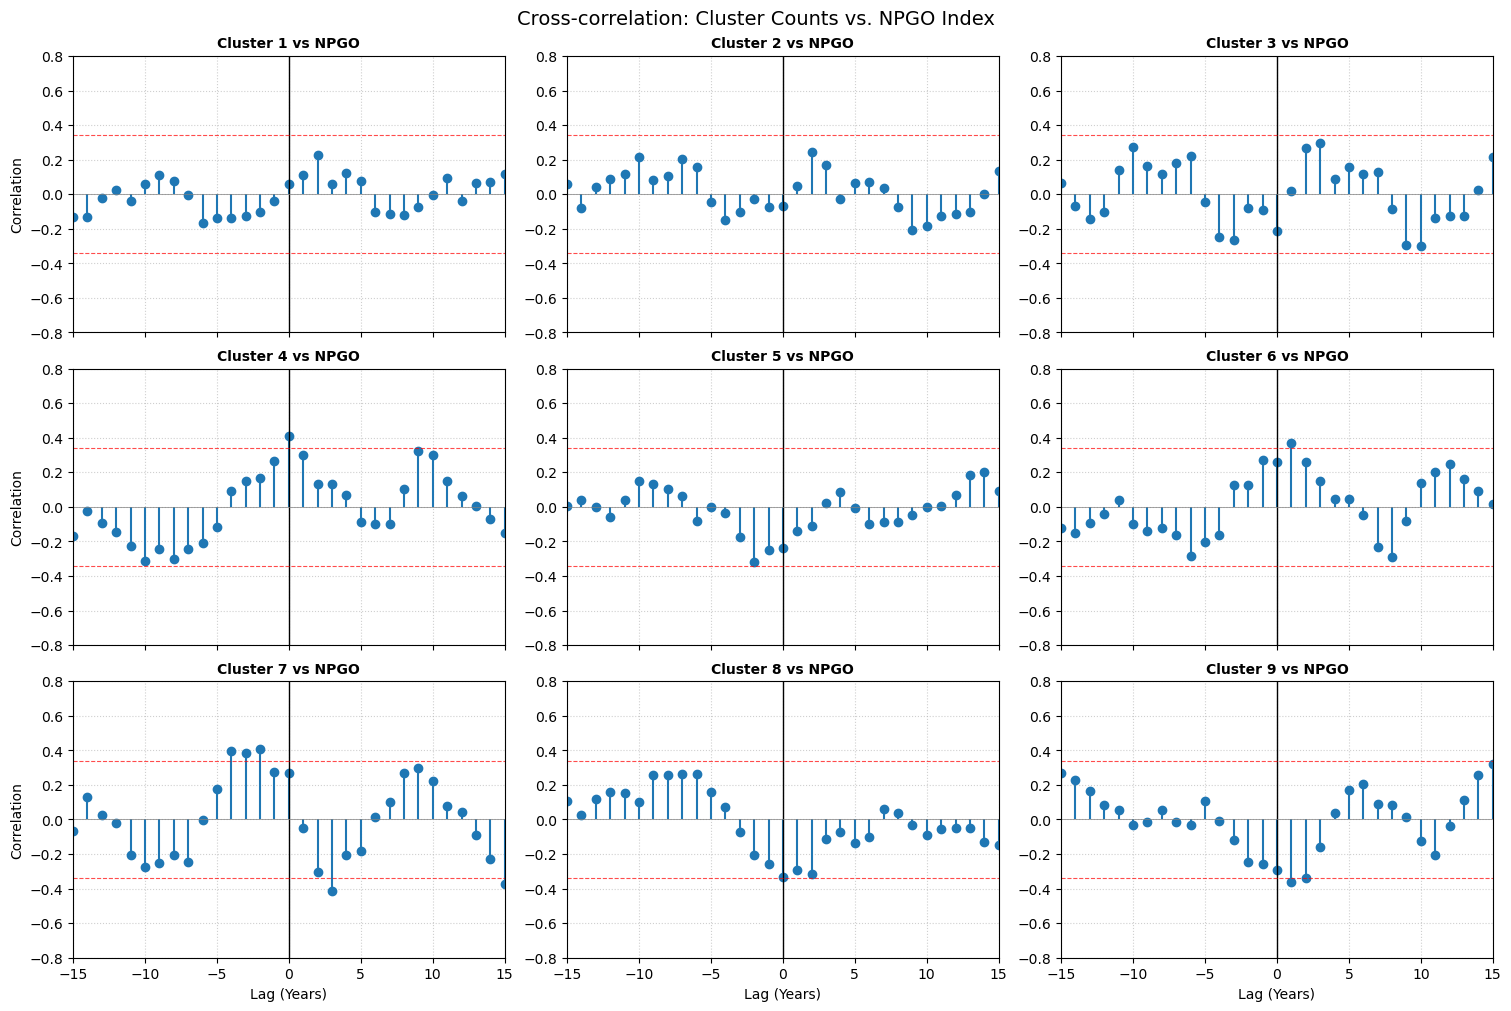

In [3]:
# 3. Plotting
fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharex=True, constrained_layout=True)

# 95% Confidence Interval Threshold
conf_interval = 1.96 / np.sqrt(len(y))

# --- Lag 제한 설정 (15년) ---
max_lag = 15

for i, ax in enumerate(axes.flat):
    if i < n_clusters:
        lags, corr = full_ccf(X[:, i], y)

        # Stem plot
        markerline, stemlines, baseline = ax.stem(lags, corr, basefmt=" ")
        plt.setp(stemlines, "linewidth", 1.5)

        # Style improvements
        ax.axvline(0, color="black", linestyle="-", linewidth=1)  # Zero lag line
        ax.axhline(0, color="gray", linewidth=0.5)

        # Significance lines (Red dashed)
        ax.axhline(conf_interval, color="red", linestyle="--", linewidth=0.8, alpha=0.7)
        ax.axhline(
            -conf_interval, color="red", linestyle="--", linewidth=0.8, alpha=0.7
        )

        ax.set_ylim(-0.8, 0.8)

        # --- X축 범위 제한 (-15 ~ +15) ---
        ax.set_xlim(-max_lag, max_lag)

        ax.set_title(f"Cluster {i + 1} vs NPGO", fontsize=10, fontweight="bold")
        ax.grid(True, linestyle=":", alpha=0.6)

        if i % 3 == 0:
            ax.set_ylabel("Correlation")
        if i >= 6:
            ax.set_xlabel("Lag (Years)")

fig.suptitle("Cross-correlation: Cluster Counts vs. NPGO Index", fontsize=14)
plt.savefig("../Results/cross-corr_npgo.png", dpi=300)
plt.show()

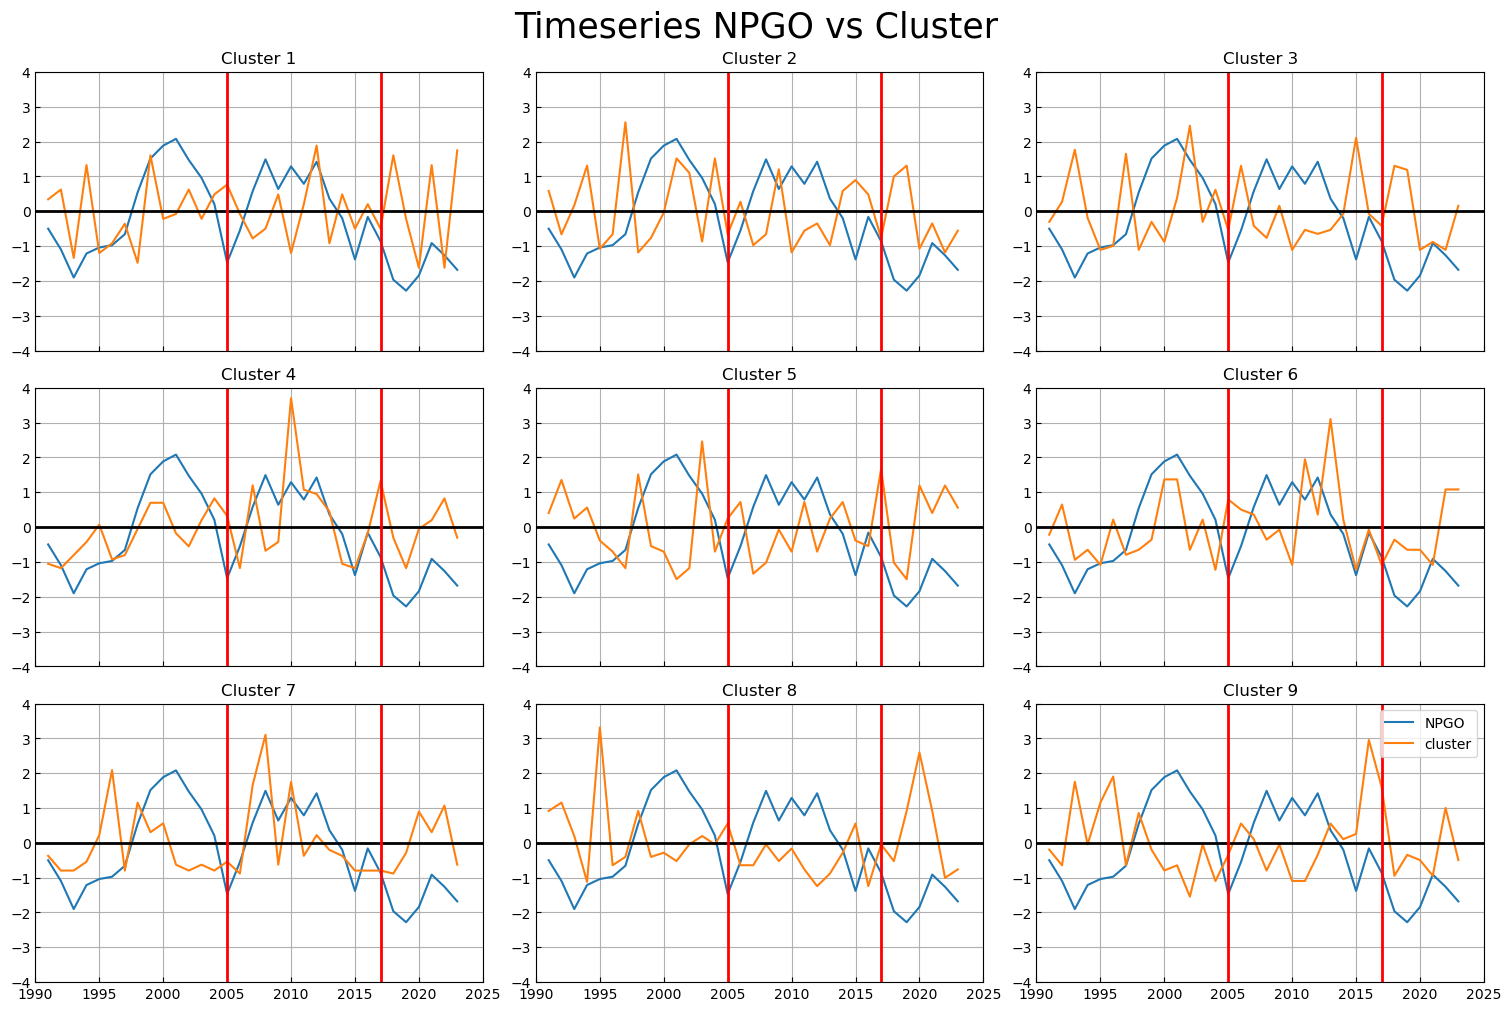

In [4]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharex=True, constrained_layout=True)
for i, ax in enumerate(axes.flat):
    xn = (X[:, i] - np.mean(X[:, i])) / np.std(X[:, i])
    ax.plot(np.linspace(1991, 2023, 33), y, label="NPGO")
    ax.plot(np.linspace(1991, 2023, 33), xn, label="cluster")
    ax.axhline(0, lw=2, color="k")
    ax.axvline(2005, lw=2, color="r")
    ax.axvline(2017, lw=2, color="r")
    ax.tick_params(axis="both", tickdir="in")
    ax.set_xlim(1990, 2025)
    ax.set_ylim(-4, 4)
    ax.grid(True)
    ax.set_title(f"Cluster {i + 1}")
    if i == 8:
        ax.legend(loc="upper right")

fig.suptitle("Timeseries NPGO vs Cluster", fontsize=25)
plt.savefig("../Results/ts_vs_npgo.png", dpi=300)
plt.show()